# Classification - CNN

This example builds on the previous example that used a simple MLP to classify digits.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/classification-CNN.ipynb)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

## Dataset

MNIST is a handwrriten digit database with a training set of 60,000 examples and a test se of 10,000 examples. The images are all 28x28 and greyscale.

It is available [here](http://yann.lecun.com/exdb/mnist/), but is included in Keras and will automatically download.

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Here, the 'x' arrays are the images and the 'y' arrays are the labels

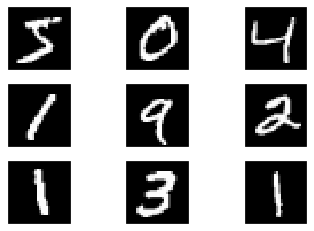

In [3]:
fig, axs = plt.subplots(3,3)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### General parameters

We need to define some general parameters for networks we're going to use

In [4]:
batch_size = 100    # number of images passed each iteration
num_classes = 10    # digits 0 to 9
max_epochs = 10     # number of full passes of the dataset

## CNN

This example uses a convolutiona neural net, in this case a 2D CNN

For a CNN the data needs to be parsed as 2D array, rather than a 1D array. 

So, the data is reshaped according to the number of samples (60,000 or 10,000) and the size of the image 28x28. We also need to add a 'channel' dimension. If the images were colour images, they would have three channels: RGB.

The data is then normalized (0,255) to (0,1)

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# reshape data
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


As is the content of the labels vectors looks like this:
```
array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)
```
The NN expects them labels as binary class matrix instead

In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Now the label for each image looks like this:
```
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)
```


### The Model

The model will have the same fundamental structure but will incorporate convolutional layers and max-pooling.

**Convolutional layers** convolve a **filter** (or kernel) with the input and output an image:

![conv](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)
Source: https://github.com/vdumoulin/conv_arithmetic

In this example the filter is 3 x 3 and there is no padding, so the size of image is reduced. Padding allows for for the size of the image to be maintained:

![conv](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)
Source: https://github.com/vdumoulin/conv_arithmetic

In Keras the default is **no padding**.

**Max pooling** is often applied after a convolutional layer and is another way a reducing the size of the image. Max pooling passes a fitler over the image and returns the maximum value from each position:

![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)
Source: http://cs231n.github.io/

In [9]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
# input to dense layer needs to be 1D array
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                36896     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 37,890
Trainable params: 37,890
Non-trainable params: 0
____________________________________________________

In [10]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = 0.01, momentum = 0.9, nesterov = True),
metrics=['acc'])

## The Training
This will be slow to run (~1-2 minutes per epoch) on a CPU

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 818us/sample - loss: 0.3627 - acc: 0.8877 - val_loss: 0.1807 - val_acc: 0.9441
Epoch 2/10
60000/60000 [==============================] - 49s 817us/sample - loss: 0.1493 - acc: 0.9553 - val_loss: 0.1116 - val_acc: 0.9640
Epoch 3/10
60000/60000 [==============================] - 55s 910us/sample - loss: 0.0999 - acc: 0.9697 - val_loss: 0.0793 - val_acc: 0.9753
Epoch 4/10
60000/60000 [==============================] - 50s 840us/sample - loss: 0.0751 - acc: 0.9765 - val_loss: 0.0634 - val_acc: 0.9781
Epoch 5/10
60000/60000 [==============================] - 54s 900us/sample - loss: 0.0595 - acc: 0.9813 - val_loss: 0.0558 - val_acc: 0.9817
Epoch 6/10
60000/60000 [==============================] - 50s 826us/sample - loss: 0.0510 - acc: 0.9840 - val_loss: 0.0545 - val_acc: 0.9821
Epoch 7/10
60000/60000 [==============================] - 50s 832us/sample - loss: 0.0434 - acc: 0.9864 

## Evaluation

Now the model is trained we can evaluate it's performance using the test set

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0462945464315766
Test accuracy: 0.9855


### Loss function

As in other examples we can consider the loss function

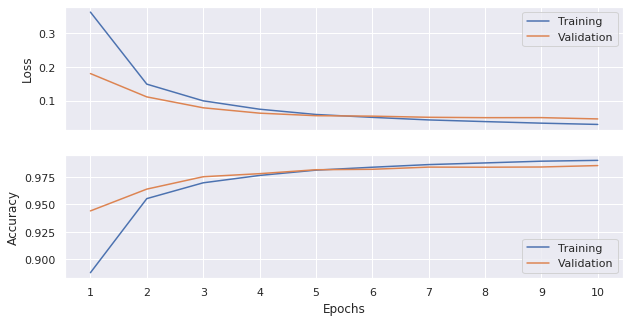

In [13]:
epochs = np.arange(1, max_epochs + 1, 1)
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)
axs = axs.ravel()
axs[0].plot(epochs, history.history["loss"], label='Training')
axs[0].plot(epochs, history.history["val_loss"], label='Validation')
axs[1].plot(epochs, history.history["acc"], label='Training')
axs[1].plot(epochs, history.history["val_acc"], label='Validation')

axs[1].set_xticks(epochs)
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epochs")

axs[0].legend()
axs[1].legend()
plt.show()

### Confusion matrix

We can use a confusion matrix again to better represent the output

In [14]:
from sklearn.metrics import confusion_matrix

#### Predictions


In [15]:
y_pred = model.predict(x_test)
print(f'Example of predicted values: \n {y_pred[0]}')
print(f'Corresponding true value: \n {y_test[0]}')

Example of predicted values: 
 [6.7923077e-11 1.3625396e-09 2.2087497e-05 1.5683307e-05 5.7369602e-11
 9.6189403e-09 1.4331083e-16 9.9996006e-01 1.5978854e-06 4.5822560e-07]
Corresponding true value: 
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [16]:
pred_class = np.argmax(y_pred, axis=1)
true_class = np.argmax(y_test, axis=1)

#### Confusion matrix

In [17]:
cm = confusion_matrix(true_class, pred_class)

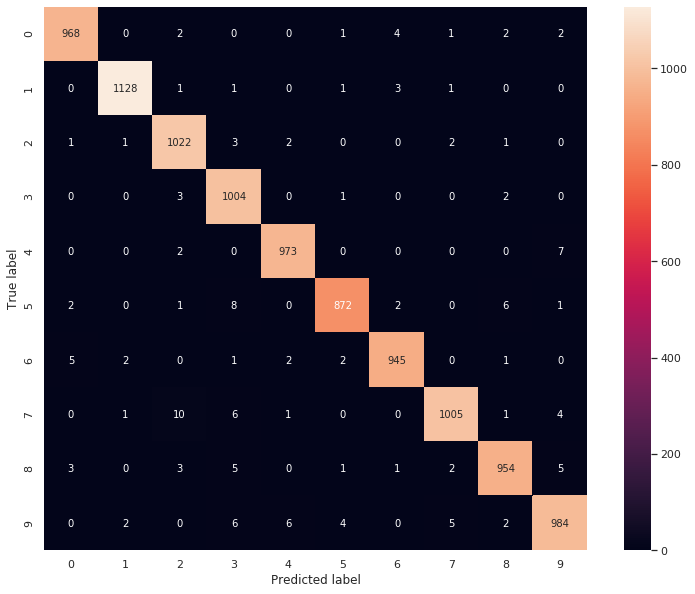

In [18]:
fig = plt.figure(figsize=(13, 10))
sns.heatmap(cm, annot=True, square=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()